In [1]:
!pip install wordcloud

  Using cached wordcloud-1.9.4-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp310-cp310-win_amd64.whl (299 kB)


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

## READING ANIMELIST.CSV

In [2]:
import os 
os.chdir("../")
os.getcwd()

'c:\\Users\\amman\\Documents\\MLOPS\\End-to-End-Anime-Recommender'

In [3]:
INPUT_DIR = os.path.join("artifacts", "raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(5000000, 3)

In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 114.4 MB


### DATA PROCESSING

In [8]:
n_ratings = rating_df["user_id"].value_counts()


In [9]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [10]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >=200].index)].copy()

In [11]:
rating_df.shape

(4377383, 3)

In [12]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [13]:
print(min_rating, max_rating)

0 10


In [14]:
avg_rating = np.mean(rating_df["rating"])
print(avg_rating)

4.221968925268819


In [15]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating) / (max_rating-min_rating)).values.astype(float)


In [16]:
avg_rating = np.mean(rating_df["rating"])

In [17]:
avg_rating

np.float64(0.4221968925268819)

In [18]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [19]:
print(min_rating, max_rating)

0.0 1.0


In [20]:
rating_df.duplicated().sum()

np.int64(0)

In [21]:
rating_df.drop_duplicates(inplace=True)

In [22]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [23]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}


In [24]:
user2user_encoded

{2: 0,
 3: 1,
 6: 2,
 11: 3,
 12: 4,
 16: 5,
 17: 6,
 19: 7,
 21: 8,
 25: 9,
 33: 10,
 34: 11,
 36: 12,
 38: 13,
 41: 14,
 42: 15,
 44: 16,
 46: 17,
 47: 18,
 49: 19,
 52: 20,
 53: 21,
 55: 22,
 60: 23,
 61: 24,
 64: 25,
 65: 26,
 66: 27,
 67: 28,
 71: 29,
 72: 30,
 73: 31,
 74: 32,
 78: 33,
 80: 34,
 81: 35,
 82: 36,
 83: 37,
 84: 38,
 85: 39,
 89: 40,
 90: 41,
 94: 42,
 98: 43,
 101: 44,
 102: 45,
 108: 46,
 110: 47,
 111: 48,
 112: 49,
 113: 50,
 117: 51,
 119: 52,
 120: 53,
 121: 54,
 122: 55,
 124: 56,
 126: 57,
 127: 58,
 129: 59,
 131: 60,
 135: 61,
 136: 62,
 138: 63,
 145: 64,
 146: 65,
 147: 66,
 148: 67,
 153: 68,
 154: 69,
 155: 70,
 156: 71,
 157: 72,
 158: 73,
 160: 74,
 163: 75,
 164: 76,
 166: 77,
 172: 78,
 173: 79,
 174: 80,
 181: 81,
 184: 82,
 185: 83,
 188: 84,
 190: 85,
 191: 86,
 193: 87,
 194: 88,
 195: 89,
 196: 90,
 197: 91,
 198: 92,
 202: 93,
 204: 94,
 205: 95,
 209: 96,
 211: 97,
 214: 98,
 215: 99,
 219: 100,
 222: 101,
 224: 102,
 227: 103,
 228: 104,
 2

In [25]:
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

In [26]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [27]:
n_users = len(user2user_encoded)

In [28]:
n_users

8134

In [29]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [30]:
n_anime = len(anime2anime_encoded)

In [31]:
n_anime

17157

In [32]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [33]:
# Shuffle data
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)


In [34]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,5455,14807,0.0,2664,629
1,15218,16099,0.7,7494,3439
2,1909,10790,0.7,933,646
3,5638,34134,0.0,2758,62
4,14777,953,0.9,7284,1628


In [35]:
X = rating_df[["user", "anime"]]
y = rating_df["rating"]

In [36]:
test_size = int(len(rating_df) * 0.02)
train_indices = rating_df.shape[0] - test_size

In [37]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],

)

In [38]:
print(len(X_train), len(X_test), len(y_train), len(y_test), sep=", ")

4289836, 87547, 4289836, 87547


In [39]:
type(X_train)

pandas.core.frame.DataFrame

In [40]:
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [41]:
print(type(X_train), type(X_test), type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [42]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [43]:
type(X_train_array)

list

In [44]:
type(X_test_array)

list

### Model Architecture

In [45]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Dropout(0.3)(x)
    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="mean_squared_error", metrics=["mae", "mse"], optimizer="Adam")
    return model




In [46]:
model = RecommenderNet()

In [47]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,041,152 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,196,096 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 1)      │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,237,254 (12.35 MB)

 Trainable params: 3,237,252 (12.35 MB)

 Non-trainable params: 2 (8.00 B)

In [48]:
start_lr = 1e-5
max_lr = 5e-4
min_lr = 1e-6
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return(max_lr - start_lr)/ramup_epochs*epoch+start_lr
    
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr 
    
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs) + min_lr

In [49]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)


In [50]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [51]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.1946 - mae: 0.3821 - mse: 0.1946 - val_loss: 0.1820 - val_mae: 0.3757 - val_mse: 0.1820 - learning_rate: 1.0000e-05
Epoch 2/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.1925 - mae: 0.3807 - mse: 0.1925 - val_loss: 0.1842 - val_mae: 0.3769 - val_mse: 0.1842 - learning_rate: 1.0800e-04
Epoch 3/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.1783 - mae: 0.3678 - mse: 0.1783 - val_loss: 0.1553 - val_mae: 0.3451 - val_mse: 0.1553 - learning_rate: 2.0600e-04
Epoch 4/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.1355 - mae: 0.3204 - mse: 0.1355 - val_loss: 0.1169 - val_mae: 0.2980 - val_mse: 0.1169 - learning_rate: 3.0400e-04
Epoch 5/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.1136 - mae: 0.2922 - mse: 0.1136 - val_loss: 0.1076 - val_mae: 0.2879 - val_mse: 0.1076 - learning_rate: 4.0200e-04
Epoch 6/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.1048 - mae: 0.2787 - mse: 0.1048 - v

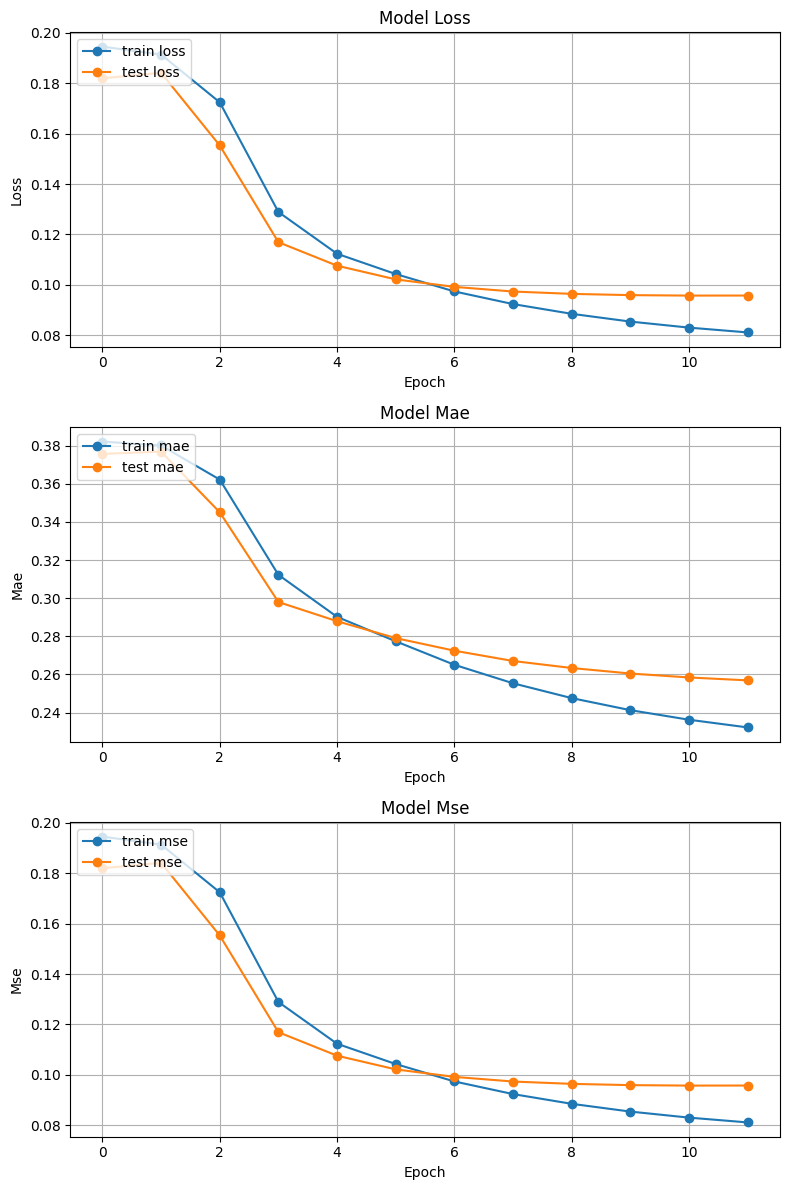

In [52]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [53]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights 

In [54]:
anime_weights = extract_weights("anime_embedding", model)

In [55]:
user_weights = extract_weights("user_embedding", model)

### READING ANIME.CSV

In [61]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)

In [62]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [63]:
df = df.replace("Unknown", np.nan)

In [64]:
def get_anime_name(anime_id):
    try:
        name = df[df["anime_id"] == anime_id]["eng_version"].values[0]
        if name is np.nan:
            name = df[df["anime_id"] == anime_id]["Name"].values[0]

    except:
        print("Error")

    return name

In [65]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df["anime_id"].apply(lambda x:get_anime_name(x))


In [66]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [67]:
df.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")

In [68]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [69]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [70]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [71]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [72]:
def get_anime_frame(anime, df):
    if isinstance(anime, int):
        return df[df["anime_id"] == anime]
    
    if isinstance(anime, str):
        return df[df["eng_version"] == anime]  

In [73]:
get_anime_frame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [74]:
get_anime_frame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### READING ANIME_WITH_SYNOPSIS.CSV

In [75]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [76]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [77]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [78]:
def get_synopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df["MAL_ID"] == anime]["sypnopsis"].values[0]
    
    if isinstance(anime, str):
        return synopsis_df[synopsis_df["Name"] == anime]["sypnopsis"].values[0]

In [79]:
get_synopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [80]:
get_synopsis("Steins;Gate", df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

## Content Based Recommmendation System

In [81]:
pd.set_option("max_colwidth", None)

In [82]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = get_anime_frame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = get_anime_frame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [83]:
find_similar_animes("Attack on Titan",
                    anime_weights,
                    anime2anime_encoded,
                    anime2anime_decoded,
                    df,
                    synopsis_df)

,name,similarity,genre
9,Tokyo Ghoul,0.669204,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen"
8,Death Note,0.648609,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
7,Sword Art Online,0.631302,"Action, Game, Adventure, Romance, Fantasy"
6,One Punch Man,0.624571,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural"
5,My Hero Academia,0.580266,"Action, Comedy, School, Shounen, Super Power"
4,Attack on Titan Season 2,0.557950,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
3,My Hero Academia 2,0.552691,"Action, Comedy, Super Power, School, Shounen"
2,Code Geass:Lelouch of the Rebellion R2,0.517867,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"
1,Naruto,0.514084,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen"
0,"No Game, No Life",0.503097,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy"


## Collaborative Filtering (User Based Recommendations)

In [84]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

In [85]:
find_similar_users(11880, user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,1723,0.344237
8,7295,0.343535
7,12572,0.341609
6,16096,0.340619
5,365,0.336836
4,10289,0.335442
3,1864,0.332384
2,7436,0.327556
1,11432,0.326832
0,11956,0.323415


In [86]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [87]:
from collections import defaultdict

In [88]:
def get_fav_genre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list

In [89]:
x = get_anime_frame(1, df)

In [90]:
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [91]:
get_fav_genre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

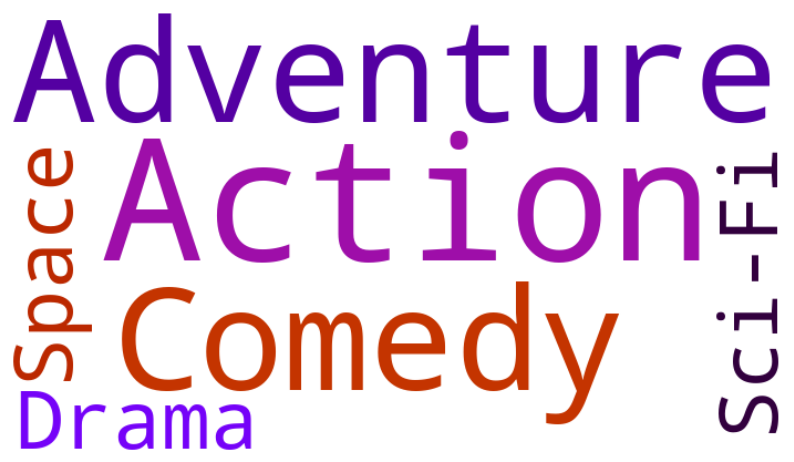

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [92]:
get_fav_genre(x, plot=True)

In [93]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df["user_id"] == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user["rating"], 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user["rating"] >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)["anime_id"].values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        get_fav_genre(anime_df_rows, plot)


    return anime_df_rows

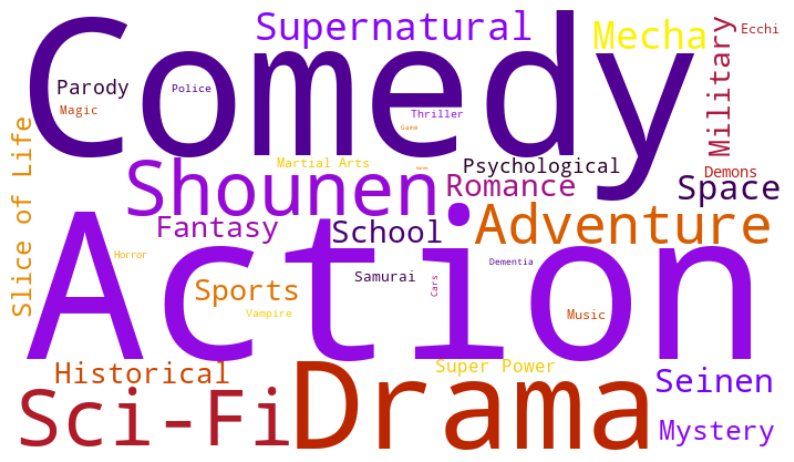

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [94]:
get_user_preferences(11880, rating_df, df, plot=True)

In [98]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users["similar_users"]:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        # Filter out animes already watched by user
        pref_list = pref_list[~pref_list["eng_version"].isin(user_pref["eng_version"].values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list["eng_version"].values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = get_anime_frame(anime_name, df)
                anime_id = frame["anime_id"].values[0]
                genre = frame["Genres"].values[0]
                synopsis = get_synopsis(int(anime_id), synopsis_df)

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)


In [99]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

In [100]:
user_prefs = get_user_preferences(int(11880), rating_df, df)

In [102]:
get_user_recommendations(similar_users, user_prefs, df, synopsis_df, rating_df)

,n,anime_name,Genres,Synopsis
0,9,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."
1,8,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
2,7,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
3,7,Your Name.,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
4,7,Princess Mononoke,"Action, Adventure, Fantasy","hen an Emishi village is attacked by a fierce demon boar, the young prince Ashitaka puts his life at stake to defend his tribe. With its dying breath, the beast curses the prince's arm, granting him demonic powers while gradually siphoning his life away. Instructed by the village elders to travel westward for a cure, Ashitaka arrives at Tatara, the

## HYBRID RECOMMENDER SYSTEM

In [111]:
def hybrid_recommendation(user_id,  user_weight=0.5, content_weight=0.5, n=10):
    ######### User Based Recommendation (Collabortaive Filtering) ################
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded, n=n)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommendations = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=n)

    user_recommendations_list = user_recommendations["anime_name"].tolist()

    ######### Content based Recommendation #############################
    content_recommended_animes = []

    for anime in user_recommendations_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=n)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        
        else:
            print(f"No similar animes found for {anime}")


    ################ Combine Recommendations ##############################
    combined_scores = {}

    for anime in user_recommendations_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:n]]


In [112]:
hybrid_recommendation(13994)

['GATE',
 'Paranoia Agent',
 'Angel Beats!',
 'No Game, No Life',
 'Toradora!',
 'Sword Art Online',
 'Your Name.',
 'Clannad',
 'Love, Chunibyo & Other Delusions!',
 'The Saga of Tanya the Evil']